In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

Loading data from drive

In [47]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

testText = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv')
testLevel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv")

In [18]:
print("Shape of train data: ", train.shape)
print("Shape of test data: ", testText.shape)

Shape of train data:  (159571, 8)
Shape of test data:  (153164, 2)


In [19]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
testText.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [16]:
testLevel.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [20]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [32]:
train[train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

Visualzing the data

<ipython-input-44-b8bd4b0944ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len,kde=False, color="blue")


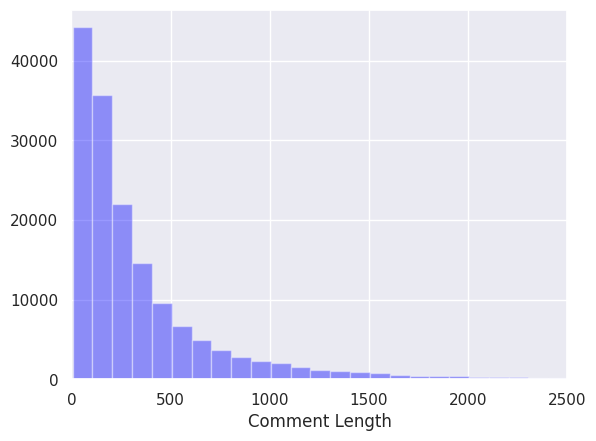

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len,kde=False, color="blue")
plt.xlim(0, 2500)

plt.xlabel('Comment Length')

# Display the plot
plt.show()

We can see most of the comments have short length and very few have length grater than 1000

Plotting the correlational matrix

<Axes: >

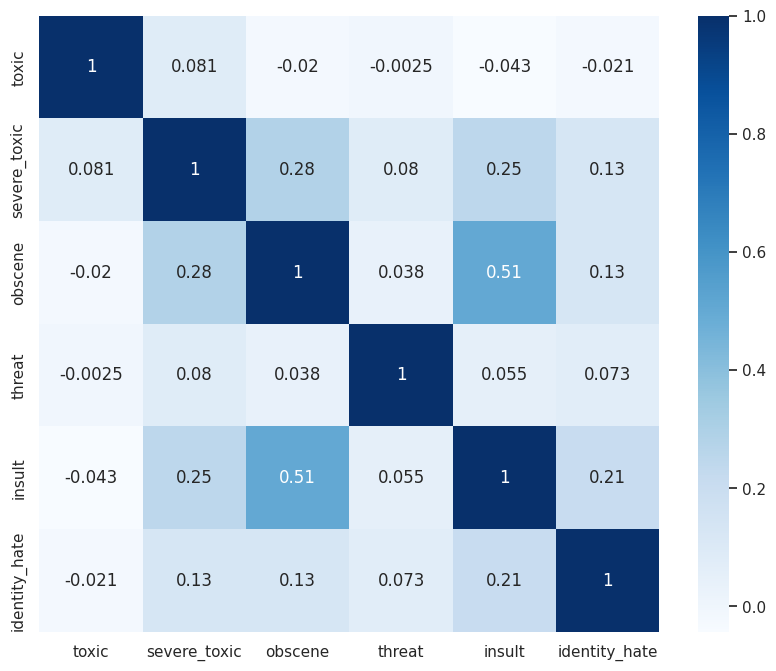

In [46]:
rowsums = train.iloc[:, 2:8].sum(axis=1)
temp = train.iloc[:, 2:8]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

The highest levels of correlation can
be observed between the obscene and toxic

Preprocessing the data



1.   Removing Characters in between Text.
2. Removing Repeated Characters.

1.   Converting data to lower-case.
2.   Removing Punctuation.
3.   Removing unnecessary white spaces in between words.
2.   Removing “\n”.
3. Removing Non-English characters.





In [36]:
import re
def clean_text(text,remove_repeat_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)  #removes repeated characters.
    # uses regular expressions (re) to find consecutive occurrences of a character
    # and replaces them with a single instance of that character.
    # For example, it replaces "loooove" with "love" by reducing consecutive repeated characters to a single occurrence

  text = str(text).replace("\n", " ") #replaces newline characters (\n) with a space character
  text = re.sub(r'[^\w\s]',' ',text) #substitute any non-alphanumeric and non-whitespace characters with a space character.
  text = re.sub('[0-9]',"",text) #remove any numeric digits from the text
  text = re.sub(" +", " ", text) #replace multiple consecutive spaces with a single space
  text = re.sub("([^\x00-\x7F])+"," ",text) #remove any non-ASCII characters from the text
  return text

In [48]:
train['comment_text'] = train['comment_text'].apply(clean_text)

In [49]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
